In [ ]:
# default_exp engine.psf

In [ ]:
%load_ext autoreload
%autoreload 2

# PSF model

> Definition of the classes and functions we use to model PSFs

In [ ]:
#export
from decode_fish.imports import *
import torch.nn as nn
from torch.jit import script
import torch.nn.functional as F
from decode_fish.funcs.utils import *

In [ ]:
#export
class LinearInterpolatedPSF(nn.Module):
    """ Stores a PSF volume parameter and enables linear subpixel interpolation

    Args:
        size_zyx: size of the psf volume in pixels
        n_cols: number of colorchannels (and therefore PSFs)
        device: 'cuda' or 'cpu'

    ToDo:
        Eventually remove unneeded losses. 
    """
    
    def __init__(self, size_zyx=[21,21,21], n_cols=1, device='cuda'):
        super().__init__()
        
        self.psf_size = list(np.array(size_zyx).astype('int'))
        self.n_cols = n_cols
        # +- /sz so that the values correspond to the pixel centers
        v = [torch.linspace(-1+1/sz, 1-1/sz, int(sz)) for sz in self.psf_size]

        # Buffers are not optimized
        self.register_buffer('x', v[2])
        self.register_buffer('y', v[1])
        self.register_buffer('z', v[0])
        self.register_buffer('z_2d', torch.zeros(1))
        self.device=device
        self.psf_volume = nn.Parameter(0.01*torch.rand(self.n_cols, *self.psf_size), requires_grad=True)
        self.forward_nonlin = torch.nn.Identity() # Could be used if one want's to save the psf volume in log space
        
    def forward(self, x_offset_val, y_offset_val, z_offset_val, z_inds=None, c_inds=None):
        """ Returns the PSF volume for a number of given subpixel shift.
        
        Args:
            x_offset_val, y_offset_val, z_offset_val: Vector of shifts in x,y,z
            z_inds: indices of the psf_slices used (only for slice data)
            c_inds: colors indices
            
        Returns:
            PSF volumes/slices shifted by x,y,z
        """

        N_em = x_offset_val.shape[0]
        # Scale offsets by size. Factor of two because range [-1,1]
        x_offset = 2 * x_offset_val.view(-1) / self.psf_size[2]  
        y_offset = 2 * y_offset_val.view(-1) / self.psf_size[1]
        if z_inds is None:
            # Treat z like the other dimensions
            z_offset = 2 * z_offset_val.view(-1) / self.psf_size[0]
            z_g = self.z.to(self.device)
            vol = self.forward_nonlin(self.psf_volume).expand(N_em, -1, -1, -1, -1).to(self.device)
        else:
            
            z_offset = 2 * z_offset_val.view(-1) / 3
            z_g = self.z_2d.to(self.device)

            # We select a 3 pixel wide volume around the indexed z slice for interpolation
            vol = torch.cat([self.psf_volume[None,:,[z-1 for z in z_inds]], 
                             self.psf_volume[None,:,z_inds], 
                             self.psf_volume[None,:,[z+1 for z in z_inds]]], dim=0).transpose(0,2).to(self.device)
            
        if c_inds is not None:
            vol = vol[torch.arange(len(c_inds)),c_inds]
            vol = vol[:,None]
        
        # Create the grids
        i_img, x_grid, y_grid, z_grid = torch.meshgrid(torch.arange(N_em, dtype=torch.float32).to(self.device), self.x.to(self.device), self.y.to(self.device), z_g)

        # Shift the grids
        x_grid = x_grid - x_offset[:, None, None, None]
        y_grid = y_grid - y_offset[:, None, None, None]
        z_grid = z_grid - z_offset[:, None, None, None]

        m_grid = torch.stack([x_grid, y_grid, z_grid], -1)
        psf_out = torch.nn.functional.grid_sample(vol, m_grid, align_corners = False)
        
        return psf_out.transpose(-3,-1)
    
    def get_com(self):
        """ Returns the center of mass of the squared volume."""
            
        x_grid, y_grid, z_grid = torch.meshgrid(torch.arange(self.psf_size[0]),torch.arange(self.psf_size[1]),torch.arange(self.psf_size[2]))
        m_grid = torch.stack([x_grid, y_grid, z_grid], -1).to(self.device)
        
        vol = (self.forward_nonlin(self.psf_volume[0])**2).to(self.device)

        zc = (m_grid[:,:,:,0] * vol).sum()/vol.sum()
        yc = (m_grid[:,:,:,1] * vol).sum()/vol.sum()
        xc = (m_grid[:,:,:,2] * vol).sum()/vol.sum()
        
        return zc, yc, xc
    
    def com_loss(self):
        """ Returns the difference between the current CoM and the center of the volume.
        
        Used as a loss term during AE training to avoid drift of the PSF.
        """
        
        return torch.norm(torch.stack(self.get_com()) - torch.tensor(self.psf_size).to(self.device)//2, 2)
    
    def clip_loss(self):
        """ Returns the 2 norm of negative values of the PSF volume. """
        return torch.norm(torch.nn.ReLU().forward(-self.psf_volume).sum(), 2)
    
    def sum_loss(self):
        """ Returns the 1 norm of the PSF volume. """
        return torch.norm(self.forward_nonlin(self.psf_volume).sum(), 1)
    
    def l1_diff_norm(self, init_vol):
        """ Returns the 1 norm of the difference to the initial volume. """
        return torch.linalg.norm((self.psf_volume - init_vol).reshape(-1), 1)

In [ ]:
psf_state = torch.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/msp300_smFISH/nb_run/msp300_smFISH_3_3/psf_init.pkl')
shape_zyx = psf_state['psf_volume'][:,].shape[-3:]
psf = LinearInterpolatedPSF(shape_zyx, n_cols=1)
psf.load_state_dict({'psf_volume':psf_state['psf_volume']}, strict=False)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


_IncompatibleKeys(missing_keys=['x', 'y', 'z', 'z_2d'], unexpected_keys=[])

In [ ]:
psf.psf_volume.shape

torch.Size([1, 21, 21, 21])

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([4, 1, 1, 21, 21])

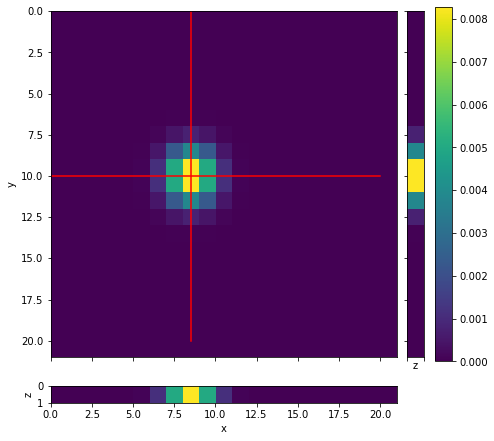

In [ ]:
from decode_fish.funcs.plotting import plot_3d_projections
shift_xyz = torch.tensor([-2,0.,+2,0.]).cuda(),torch.tensor([-.5,0.,0.,0.]).cuda(),torch.tensor([0.,0.,0.,0.]).cuda()
shifted_psf = psf(shift_xyz[0],shift_xyz[1],shift_xyz[2], [7,6,4,2])
# First output is the volume_shifted_psf 2 pixels to the left.
fig, ax = plot_3d_projections(cpu(shifted_psf)[0,0])
ax[0].plot([10.5+shift_xyz[0][0],10.5+shift_xyz[0][0]],[0,20], 'red') 
ax[0].plot([0,20], [10.5+shift_xyz[1][0],10.5+shift_xyz[1][0]], 'red')
shifted_psf.shape

In [ ]:
#export
def crop_psf(psf, extent_zyx):
    """Returns a cropped version of a PSF"""
    cropped_vol = center_crop(psf.psf_volume, extent_zyx)
    cropped_psf = LinearInterpolatedPSF(extent_zyx)
    cropped_psf.load_state_dict({'psf_volume':cropped_vol}, strict=False)
    return cropped_psf

(<Figure size 701.486x658.286 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

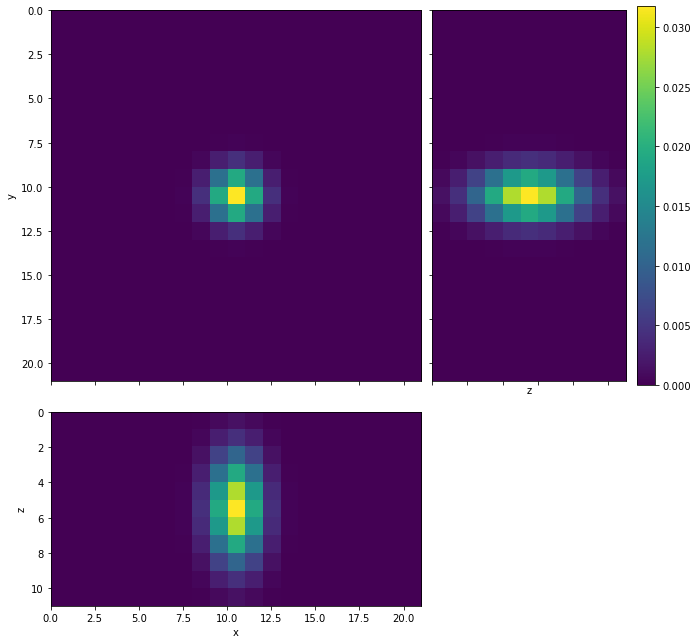

In [ ]:
cropped_psf = crop_psf(psf,[11,21,21])
plot_3d_projections(cropped_psf.psf_volume)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
